# DeepDeWedge Tutorial

This is a minimal example for how to apply DeepDeWedge.

In [1]:
import os
import torch
import math
from setup_dataset import setup_fitting_and_val_dataset
import pytorch_lightning as pl
from pytorch_lightning import seed_everything
from utils.mrctools import load_mrc_data
from matplotlib import pyplot as plt

from unet import Unet3D
from masked_loss import masked_loss
from normalization import get_avg_model_input_mean_and_var
from utils.visualization import plot_tomo_slices
import shutil
from torchsummary import summary
from refine_tomogram import refine_tomogram

from utils.dataloader import MultiEpochsDataLoader as DataLoader


seed_everything(42)


/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 42


42

## Download the tutorial dataset
We apply DeepDeWedge to the Wiener-Filter CTF corrected FBP reconstructon of tilt series 05 of EMPIAR-10045. First, we download the tutorial dataset which contains FBP reconstructions from the even, odd and full tilt series. We binned these reconstructions by a factor of 6 using average pooling, which results in a physical voxel size of 13.02 Angstroms. For CTF correction, we used the Wiener-like filter implemented in IsoNet (https://github.com/IsoNet-cryoET/IsoNet).

The following two lines of code download the data as .zip archive and unzip it. Upon successful completion, you will find a new subdirectory 


In [2]:
# download data with wget
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1_yuI2Xu2ISnuBKT3FS_9cqdAXvC2Shh8' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1_yuI2Xu2ISnuBKT3FS_9cqdAXvC2Shh8" -O tutorial_data.zip && rm -rf /tmp/cookies.txt
# !unzip tutorial_data.zip
# !rm tutorial_data.zip

/workspaces/DeepDeWedge/utils/mrctools.py:8: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:172.)
  data = torch.from_numpy(mrc.data)


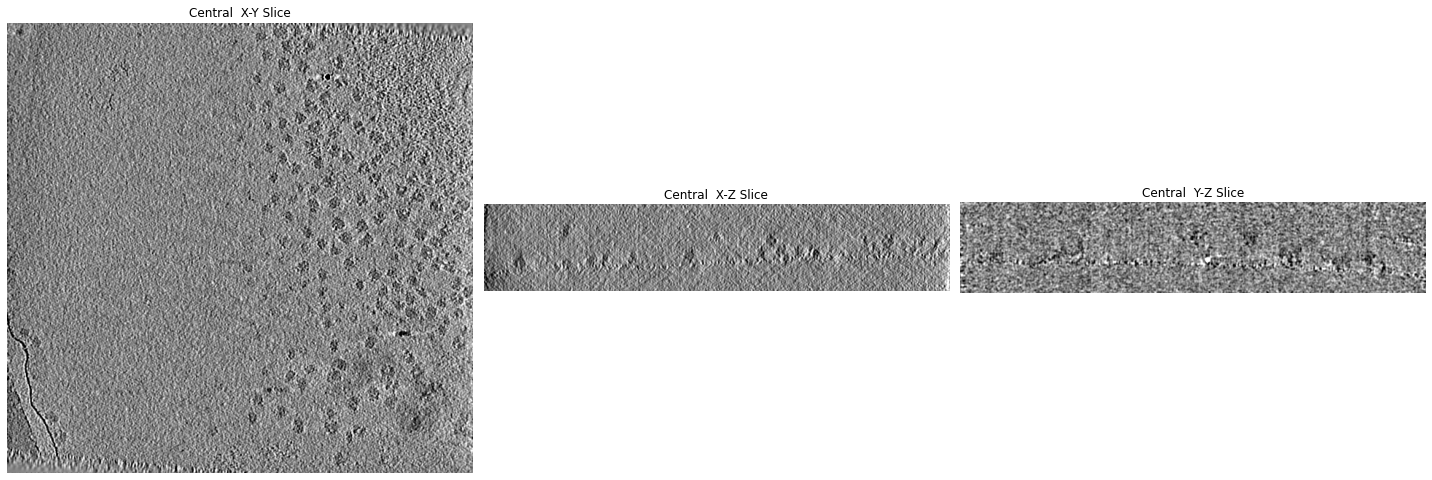

In [3]:
tomo_full = load_mrc_data("./tutorial_data/IS002_291013_006_FullFBP_Bin6_Wiener.mrc")
plot_tomo_slices(
    tomo_full.clamp(-3 * tomo_full.std(), 3 * tomo_full.std()), figsize=(20, 10)
).show()


## Setup datasets for model fitting
We first load the dataset for model fitting. The function `setup_fitting_and_val_dataset` returns two torch datasets, one for model fitting and one for validation to prevent overfitting. The tomograms corresponding to the filepaths in `tomo0_files` are used to construct the model inputs, while the ones in `tomo1_files` are used to construct the targets. 

Both the fitting and the validation dataset return model inputs and targets with shape `subtomo_size x subtomo_size x subtomo_size`. These subtomograms are extracted from the tomograms using x, y and z direction strides specified in `subtomo_extraction_strides`. To reduce RAM consumption during model fitting, all subtomograms are saved to the directory `save_subtomos_to`, which is created if it doe note exist.

The number of elements in the validation set is at most `validation_frac` times the number of total extracted subtomograms. It may also contain fewer subtomograms since we randomly sample the validation subtomograms such that they have no overlap with the ones used for model fitting. If the sampling procedure was unable to sample enough validation subtomograms, the function prints a warning.

In [4]:
shutil.rmtree("./subtomos/", ignore_errors=True)

fitting_dataset, val_dataset = setup_fitting_and_val_dataset(
    tomo0_files=["./tutorial_data/IS002_291013_006_EvenFBP_Bin6_Wiener.mrc"],
    tomo1_files=["./tutorial_data/IS002_291013_006_OddFBP_Bin6_Wiener.mrc"],
    subtomo_size=80,
    subtomo_extraction_strides=[40, 40, 40],
    mw_angle=60,
    val_fraction=0.2,
    save_subtomos_to="./subtomos/",
)

print(f"Number of subtomograms for model fitting: {len(fitting_dataset)}")
print(f"Number of subtomos for validation: {len(val_dataset)}")


Number of subtomograms for model fitting: 146
Number of subtomos for validation: 36


Both the fitting and the validation dataset return dictionries containing the following items:
* `model_input`: A model input $\tilde{\mathbf{v}}_\varphi^0$ with two missing wedges
* `model_target`: A model target $\tilde{\mathbf{v}}_\varphi^1$ with only one missing wedge
* `rot_mw_mask`: The rotated missing wedge mask $\mathbf{M}_\varphi$
* `mw_mask`: The original missing wedge mask $\mathbf{M}$. This mask is the same for all elements in the dataset.

**Note**: The rotation angles $\varphi$ in the training set are always random, and are re-sampled every time an item is queried. For the validation dataset, we only sample random rotation angles once and every item always has its fixed rotation.


Let's now have a look at the real and Fourier domain representation of some of the model inputs:

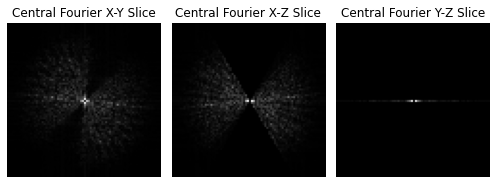

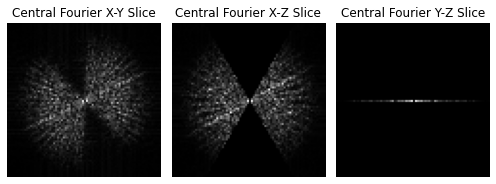

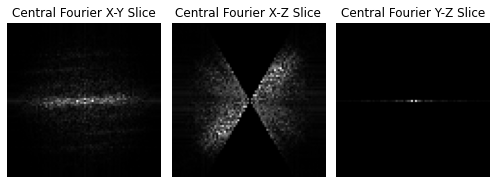

In [5]:
for k in range(3):
    item = fitting_dataset[k]
    model_input = item["model_input"]
    model_input -= model_input.mean()
    plot_tomo_slices(item["model_input"], domain="fourier").show()


We create a fitting and a validation dataloader which return batches of elements from the fitting and validation sets:

In [6]:
batch_size = 5
num_workers = 10

fitting_dataloader = DataLoader(
    dataset=fitting_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    pin_memory=True,
)
val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False,
    pin_memory=True,
)


## Fit the model

First, we setup a 3D U-Net. The architecture we implemented in `unet.py`is the same used in the official IsoNet implementation.
Before we can start model fitting, we calculate the average mean and variance of the model inputs in the fitting dataset. We use these values to normalize the input to the U-Net during model fitting.

In [7]:
unet_params = {
    "in_chans": 1,
    "out_chans": 1,
    "chans": 64,
    "num_downsample_layers": 3,
    "drop_prob": 0.0,
}

avg_model_input_mean, avg_model_input_var = get_avg_model_input_mean_and_var(
    fitting_dataloader,
    batches=3
    * len(
        fitting_dataloader
    ),  # compute mean and variance of the model inputs using three passes through the entire dataset
    verbose=True,
)
unet_params["normalization_loc"] = avg_model_input_mean
unet_params["normalization_scale"] = math.sqrt(avg_model_input_var)


Getting average model input mean and variance: 100%|██████████| 90/90 [00:56<00:00,  1.59it/s]


Average model input mean: 0.028363652527332306 (Variance over inputs: 0.0002518684195820242)
Average model input varariance: 0.23283961415290833 (Variance over inputs: 0.0031270890031009912)


For conventient model fitting, we use the [PyTorch lightning](https://lightning.ai/pytorch-lightning/) framework. Below, we define the class `LitUnet3D`, which takes parameters for a U-Net and the `torch.optim.Adam` optimizer as input and can then be used to fit the U-Net using PyTroch lightning. The two most important methods of this class are:
* `training_step`: This step handles passing the model inputs provided by the fitting dataloader through the model and calculating the loss. 
+ `validation_step`: In this step, we can implement any validation routine we like. For simplicity, we just calculate the loss on the validation set to monitor overfitting. Depending on which logger we use, we can for example also log plots of the model output.

In [8]:
class LitUnet3D(pl.LightningModule):
    def __init__(self, unet_params, adam_params):
        super().__init__()
        self.unet_params = unet_params
        self.adam_params = adam_params
        self.unet = Unet3D(**self.unet_params)
        self.save_hyperparameters()

    def forward(self, x):
        return self.unet(x.unsqueeze(1)).squeeze(
            1
        )  # unsqueeze to add channel dimension, squeeze to remove it

    def training_step(self, batch, batch_idx):
        model_output = self(batch["model_input"])
        loss = masked_loss(
            model_output=model_output,
            target=batch["model_target"],
            rot_mw_mask=batch["rot_mw_mask"],
            mw_mask=batch["mw_mask"],
        )
        self.log(
            "train_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True
        )
        return loss

    def validation_step(self, batch, batch_idx):
        model_output = self(batch["model_input"])
        loss = masked_loss(
            model_output=model_output,
            target=batch["model_target"],
            rot_mw_mask=batch["rot_mw_mask"],
            mw_mask=batch["mw_mask"],
        )
        self.log(
            "val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True
        )

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), **self.adam_params)
        return optimizer


In [9]:
lit_unet = LitUnet3D(unet_params=unet_params, adam_params={"lr": 4e-4})
summary(
    lit_unet, input_size=(80, 80, 80), device="cpu"
)  # prints the model architecture as well as the forward and backward pass size for an input sub-tomogram with shape 80x80x80


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 64, 80, 80, 80]           1,792
       BatchNorm3d-2       [-1, 64, 80, 80, 80]             128
         Dropout3d-3       [-1, 64, 80, 80, 80]               0
         LeakyReLU-4       [-1, 64, 80, 80, 80]               0
            Conv3d-5       [-1, 64, 80, 80, 80]         110,656
       BatchNorm3d-6       [-1, 64, 80, 80, 80]             128
         Dropout3d-7       [-1, 64, 80, 80, 80]               0
         LeakyReLU-8       [-1, 64, 80, 80, 80]               0
            Conv3d-9       [-1, 64, 80, 80, 80]         110,656
      BatchNorm3d-10       [-1, 64, 80, 80, 80]             128
        Dropout3d-11       [-1, 64, 80, 80, 80]               0
        LeakyReLU-12       [-1, 64, 80, 80, 80]               0
    DownConvBlock-13       [-1, 64, 80, 80, 80]               0
           Conv3d-14       [-1, 64, 40,

PyTorch Lightning's ``Trainer`` will do the heavy lifting for us. In this tutorial, we only specify the bare minimum of parameters such as the number of epochs for model fitting `max_epochs`, and the GPU used for fitting. For more advanced functionality, please refer to the [documentation](https://lightning.ai/docs/pytorch/stable/common/trainer.html) of the ``Trainer`` class.

In [10]:
trainer = pl.Trainer(
    max_epochs=50,  # you can fit for longer but 50 epochs should alredy give a decent result
    accelerator="gpu",
    devices=[3],
    check_val_every_n_epoch=1,
    deterministic=True,  # to ensure reproducability
    logger=pl.loggers.CSVLogger(
        "csv_logs", name="tutorial"
    ),  # the logger creates a folder "csv_logs" and saves all logs as csv files there
    # logger=pl.loggers.TensorBoardLogger("tensorboard_logs", name="tutorial"),  # the TensorBoard logger offers more functionality than the CSVLogger
    callbacks=[
        pl.callbacks.ModelCheckpoint(
            dirpath="./ckpts", filename="{epoch}-{val_loss:.5f}", save_top_k=-1
        )
    ],
)
trainer.fit(lit_unet, fitting_dataloader, val_dataloader)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:606: UserWarning: Checkpoint directory /workspaces/DeepDeWedge/ckpts exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type   | Params
--------------------------------
0 | unet | Unet3D | 27.3 M
--------------------------------
27.3 M    Trainable params
2         Non-trainable params
27.3 M    Total params
109.311   Total estimated model params size (MB)


/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:1559: PossibleUserWarning: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Epoch 49: 100%|██████████| 38/38 [00:32<00:00,  1.16it/s, loss=0.42, v_num=8, val_loss=0.428, train_loss=0.417] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 38/38 [00:33<00:00,  1.14it/s, loss=0.42, v_num=8, val_loss=0.428, train_loss=0.417]


## Refine the full FBP reconstruction

We now apply the fitted model to the full FBP reconstruction. 

Processing subtomos: 100%|██████████| 68/68 [00:52<00:00,  1.29it/s]


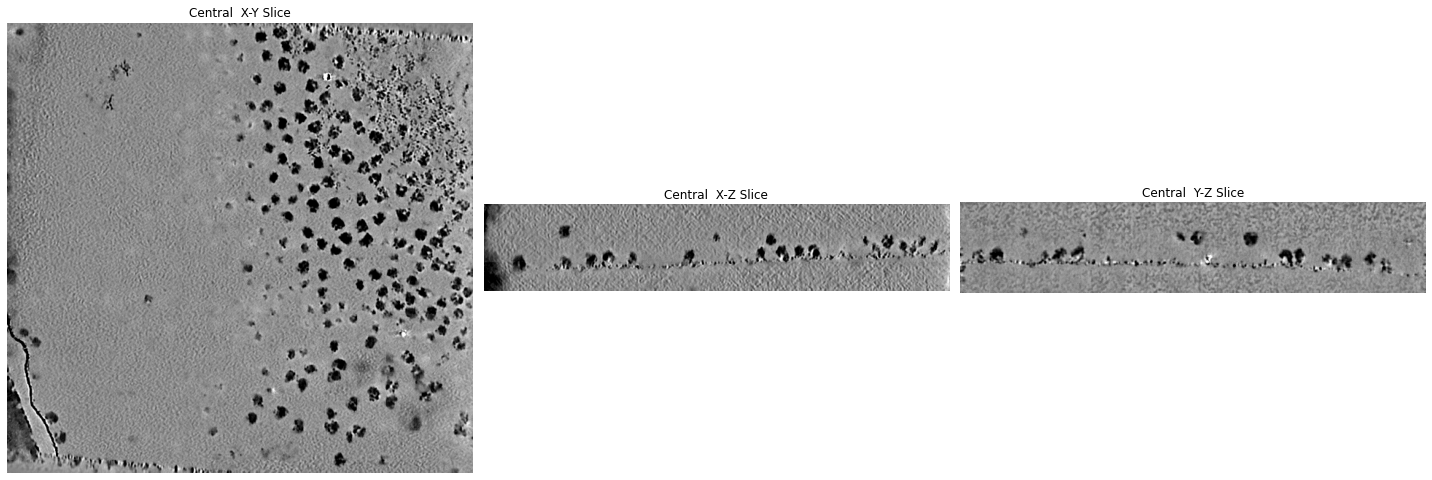

In [11]:
tomo_ref = refine_tomogram(
    tomo=tomo_full.cuda(1),
    lightning_model=lit_unet.cuda(1),
    subtomo_size=80,
    subtomo_extraction_strides=[40, 40, 40],
    batch_size=10,
)
tomo_ref = tomo_ref.cpu()
plot_tomo_slices(
    tomo_ref.clamp(-3 * tomo_ref.std(), 3 * tomo_ref.std()), figsize=(20, 10)
).show()
